In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/secondary-mushroom-dataset-data-set/MushroomDataset/primary_data_meta.txt
/kaggle/input/secondary-mushroom-dataset-data-set/MushroomDataset/secondary_data_meta.txt
/kaggle/input/secondary-mushroom-dataset-data-set/MushroomDataset/primary_data.csv
/kaggle/input/secondary-mushroom-dataset-data-set/MushroomDataset/secondary_data.csv
/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


### Installing Libraries and Importing Necessary Modules

In this section, the `xgboost` and `wget` libraries, which are not installed by default, are installed using the `!pip install` command. Then, standard libraries such as `warnings`, `string`, and third-party libraries like `pandas`, `numpy`, and `matplotlib` are imported for data processing and visualization.

In the following sections, libraries from `sklearn` are used for machine learning modeling, and `scipy` libraries are used for statistical processing.


In [2]:
!pip install xgboost
!pip install wget
# Standard
import warnings
import string
import wget
# Third-party
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import gc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, matthews_corrcoef

from xgboost import XGBClassifier


warnings.filterwarnings('ignore')

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=94ceb8e108a8b8f55f3c14245778a42126bf878e6d3b0b13824dc5a56c347fda
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [3]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 
   
# fetch dataset 
secondary_mushroom = fetch_ucirepo(id=848) 
  
# data (as pandas dataframes) 
X_original = secondary_mushroom.data.features 
y_original = secondary_mushroom.data.targets 
  
# metadata 
print(secondary_mushroom.metadata) 
  
# variable information 
print(secondary_mushroom.variables) 

{'uci_id': 848, 'name': 'Secondary Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/848/data.csv', 'abstract': 'Dataset of simulated mushrooms for binary classification into edible and poisonous.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 61068, 'num_features': 20, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2021, 'last_updated': 'Wed Apr 10 2024', 'dataset_doi': '10.24432/C5FP5Q', 'creators': ['Dennis Wagner', 'D. Heider', 'Georges Hattab'], 'intro_paper': {'title': 'Mushroom data creation, curation, and simulation to support classification tasks', 'authors': 'Dennis Wagner, D. Heider, Georges Hattab', 'published_in': 'Scientific Reports', 'year': 2021, 'url': 'https://www.semanticscholar.org/

### Creating a Copy of the Original Data

In this section, a copy of the original feature set (`X_original`) is created and stored in the `original_data` variable. Then, the target variable (`y_original`) is added as a new column called `'class'` to the copied data. This ensures that the original data remains unmodified, while the copied data can be used for further processing and analysis.

---

### Loading and Preparing the Data

Here, the training and test data are loaded using `pd.read_csv()` from the specified file paths. The following steps are performed:
- The 'id' column is dropped from the training data as it is not needed for modeling.
- The original data, which includes both features and the target column, is concatenated with the newly loaded training data.
- Any duplicate entries in the dataset are removed to ensure that only unique records are retained.
- The test data and sample submission files are also loaded for later use.

A quick view of the training data shape is printed to confirm the dimensions of the loaded dataset.

---

### Extracting Test IDs

In this part, the `id` column from the test dataset is extracted and stored in the `test_ids` variable. This is necessary for future predictions, where these IDs will be used to match the predicted results with the correct test instances.


In [4]:
original_data = X_original.copy()
original_data['class'] = y_original

In [5]:
# load data
df_train = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv').drop(['id'], axis=1)
df_train = pd.concat([df_train, original_data], ignore_index=True)
df = df_train.drop_duplicates(subset=df_train.columns.to_list().remove('class'), keep='first')
test = pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv")
sub = pd.read_csv("/kaggle/input/playground-series-s4e8/sample_submission.csv")

# quick view
print("Training data shape:", df.shape)

Training data shape: (3177868, 21)


In [6]:
test_ids = test['id']
test = test.drop(columns=['id'], axis=1)


In [7]:
# explore dataset
print("\nDataset Info:")
print(df.info())
print("-----------------------------------------\nFirst few rows:")
df.head()
df.columns


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 3177868 entries, 0 to 3178013
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 533.4+ MB
None
------------

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

### Preprocessing Categorical and Numeric Data

In this section, a function `preprocess_categorical_data(df)` is defined to handle missing or invalid values in the dataset. The function performs two main tasks:
1. **Replacing Non-Alphabetical Characters in Categorical Columns**: 
   - A helper function `replace_non_alphabetical()` is used to replace non-alphabetical values with `NaN` unless the value is a single alphabetical character. This is useful for cleaning noisy categorical data.
   
2. **Imputing Missing Values**: 
   - Missing values in **categorical columns** are imputed using the mode (most frequent value). If the mode is not available, a fallback value of `'Unknown'` is used to ensure no gaps remain.
   - Missing values in **numeric columns** are imputed using the median, as the median is less sensitive to outliers compared to the mean.

The function ensures that both categorical and numeric columns are clean and ready for modeling.

---

### Applying the Preprocessing Function to the Dataset

After defining the preprocessing function, it is applied to both the training (`df`) and test datasets to clean and impute missing values. A summary is printed after processing to check if any missing values remain in either the training or test data. This step ensures that the datasets are fully processed and ready for further analysis or modeling.


In [8]:
def preprocess_categorical_data(df):
    """
    Preprocesses the DataFrame by replacing non-alphabetical characters in categorical columns 
    and imputing missing values in categorical columns using mode and in numeric columns using median.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    
    Returns:
    - pd.DataFrame: The processed DataFrame.
    """
    def replace_non_alphabetical(value):
        """Replaces non-alphabetical values with NaN if they are not a single character."""
        if isinstance(value, str) and (len(value) == 1 and value.isalpha()):
            return value
        return np.nan

    # Identify categorical and numeric columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns

    # Replace non-alphabetical values with NaN in categorical columns
    for col in categorical_columns:
        df[col] = df[col].apply(replace_non_alphabetical)
    
    # Impute missing values in categorical columns using mode
    for col in categorical_columns:
        if df[col].isnull().any():
            mode_value = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'  # Safe mode handling
            df[col].fillna(mode_value, inplace=True)
    
    # Impute missing values in numeric columns using median
    for col in numeric_columns:
        if df[col].isnull().any():
            median_value = df[col].median()
            df[col].fillna(median_value, inplace=True)

    return df

In [9]:
# Apply the functions to train and test data
print("Imputing noise with mode for categoricals and median for numericals...")
df = preprocess_categorical_data(df)
test = preprocess_categorical_data(test)
# Print summary of missing values after processing
print("\nMissing values in train_data after processing: ", df.isnull().sum().sum())
print("\nMissing values in test_data after processing: ", test.isnull().sum().sum())

Imputing noise with mode for categoricals and median for numericals...

Missing values in train_data after processing:  0

Missing values in test_data after processing:  0


### Visualizing the Distribution of Categorical Features

In this section, the function `visualize_categorical_distributions(df)` is defined to create bar plots of the categorical features in the DataFrame. The main purpose is to visually analyze the distribution of each categorical feature, which is useful for understanding the structure and balance of categories within the dataset.

#### Function Breakdown:
1. **Identifying Categorical Columns**: 
   - The function begins by identifying the categorical columns in the DataFrame using `select_dtypes(include=['object'])`.
   
2. **Setting Up the Plot Grid**: 
   - A subplot grid is created based on the number of categorical columns. The grid is arranged in a 3-column layout with enough rows to accommodate all columns.
   - The overall figure size is adjusted dynamically depending on the number of rows, ensuring that each plot has enough space.

3. **Plotting Each Categorical Column**: 
   - For each categorical column, a bar plot is created using Seaborn (`sns.barplot`), where:
     - The x-axis represents the unique categories in the column.
     - The y-axis shows the count of each category.
   - Titles and labels are set for each subplot to clearly indicate which feature is being visualized.

4. **Cleaning Up Unused Subplots**: 
   - If there are fewer categorical columns than the total number of subplots, the unused subplots are removed to make the visualization cleaner.

5. **Final Layout Adjustments**: 
   - The layout is adjusted to provide proper spacing between the plots and the overall title of the figure.

By running the `visualize_categorical_distributions(df)` function, you get a series of bar plots for each categorical feature in the DataFrame, helping to visually understand the distribution of categories and detect any imbalances or patterns in the data.


In [10]:
# Data Visualization and Analysis
def visualize_categorical_distributions(df):
    """
    Visualizes the distribution of categorical features in the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the categorical features to visualize.
    
    Returns:
    - None: Displays the plots.
    """
    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns

    # Set up the figure for multiple subplots
    num_cols = 3  # Number of columns for the subplot grid
    num_rows = (len(categorical_columns) + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    fig.suptitle('Distribution of Categorical Features', fontsize=16)

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each categorical column and create a bar plot
    for i, col in enumerate(categorical_columns):
        sns.barplot(
            x=df[col].value_counts().index, 
            y=df[col].value_counts().values, 
            ax=axes[i], 
            palette="viridis"
        )
        # Setting titles and labels
        axes[i].set_title(f'Distribution of {col}', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)
        axes[i].set_ylabel('Count', fontsize=12)
        axes[i].tick_params(axis='x')

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the main title space
    plt.show()

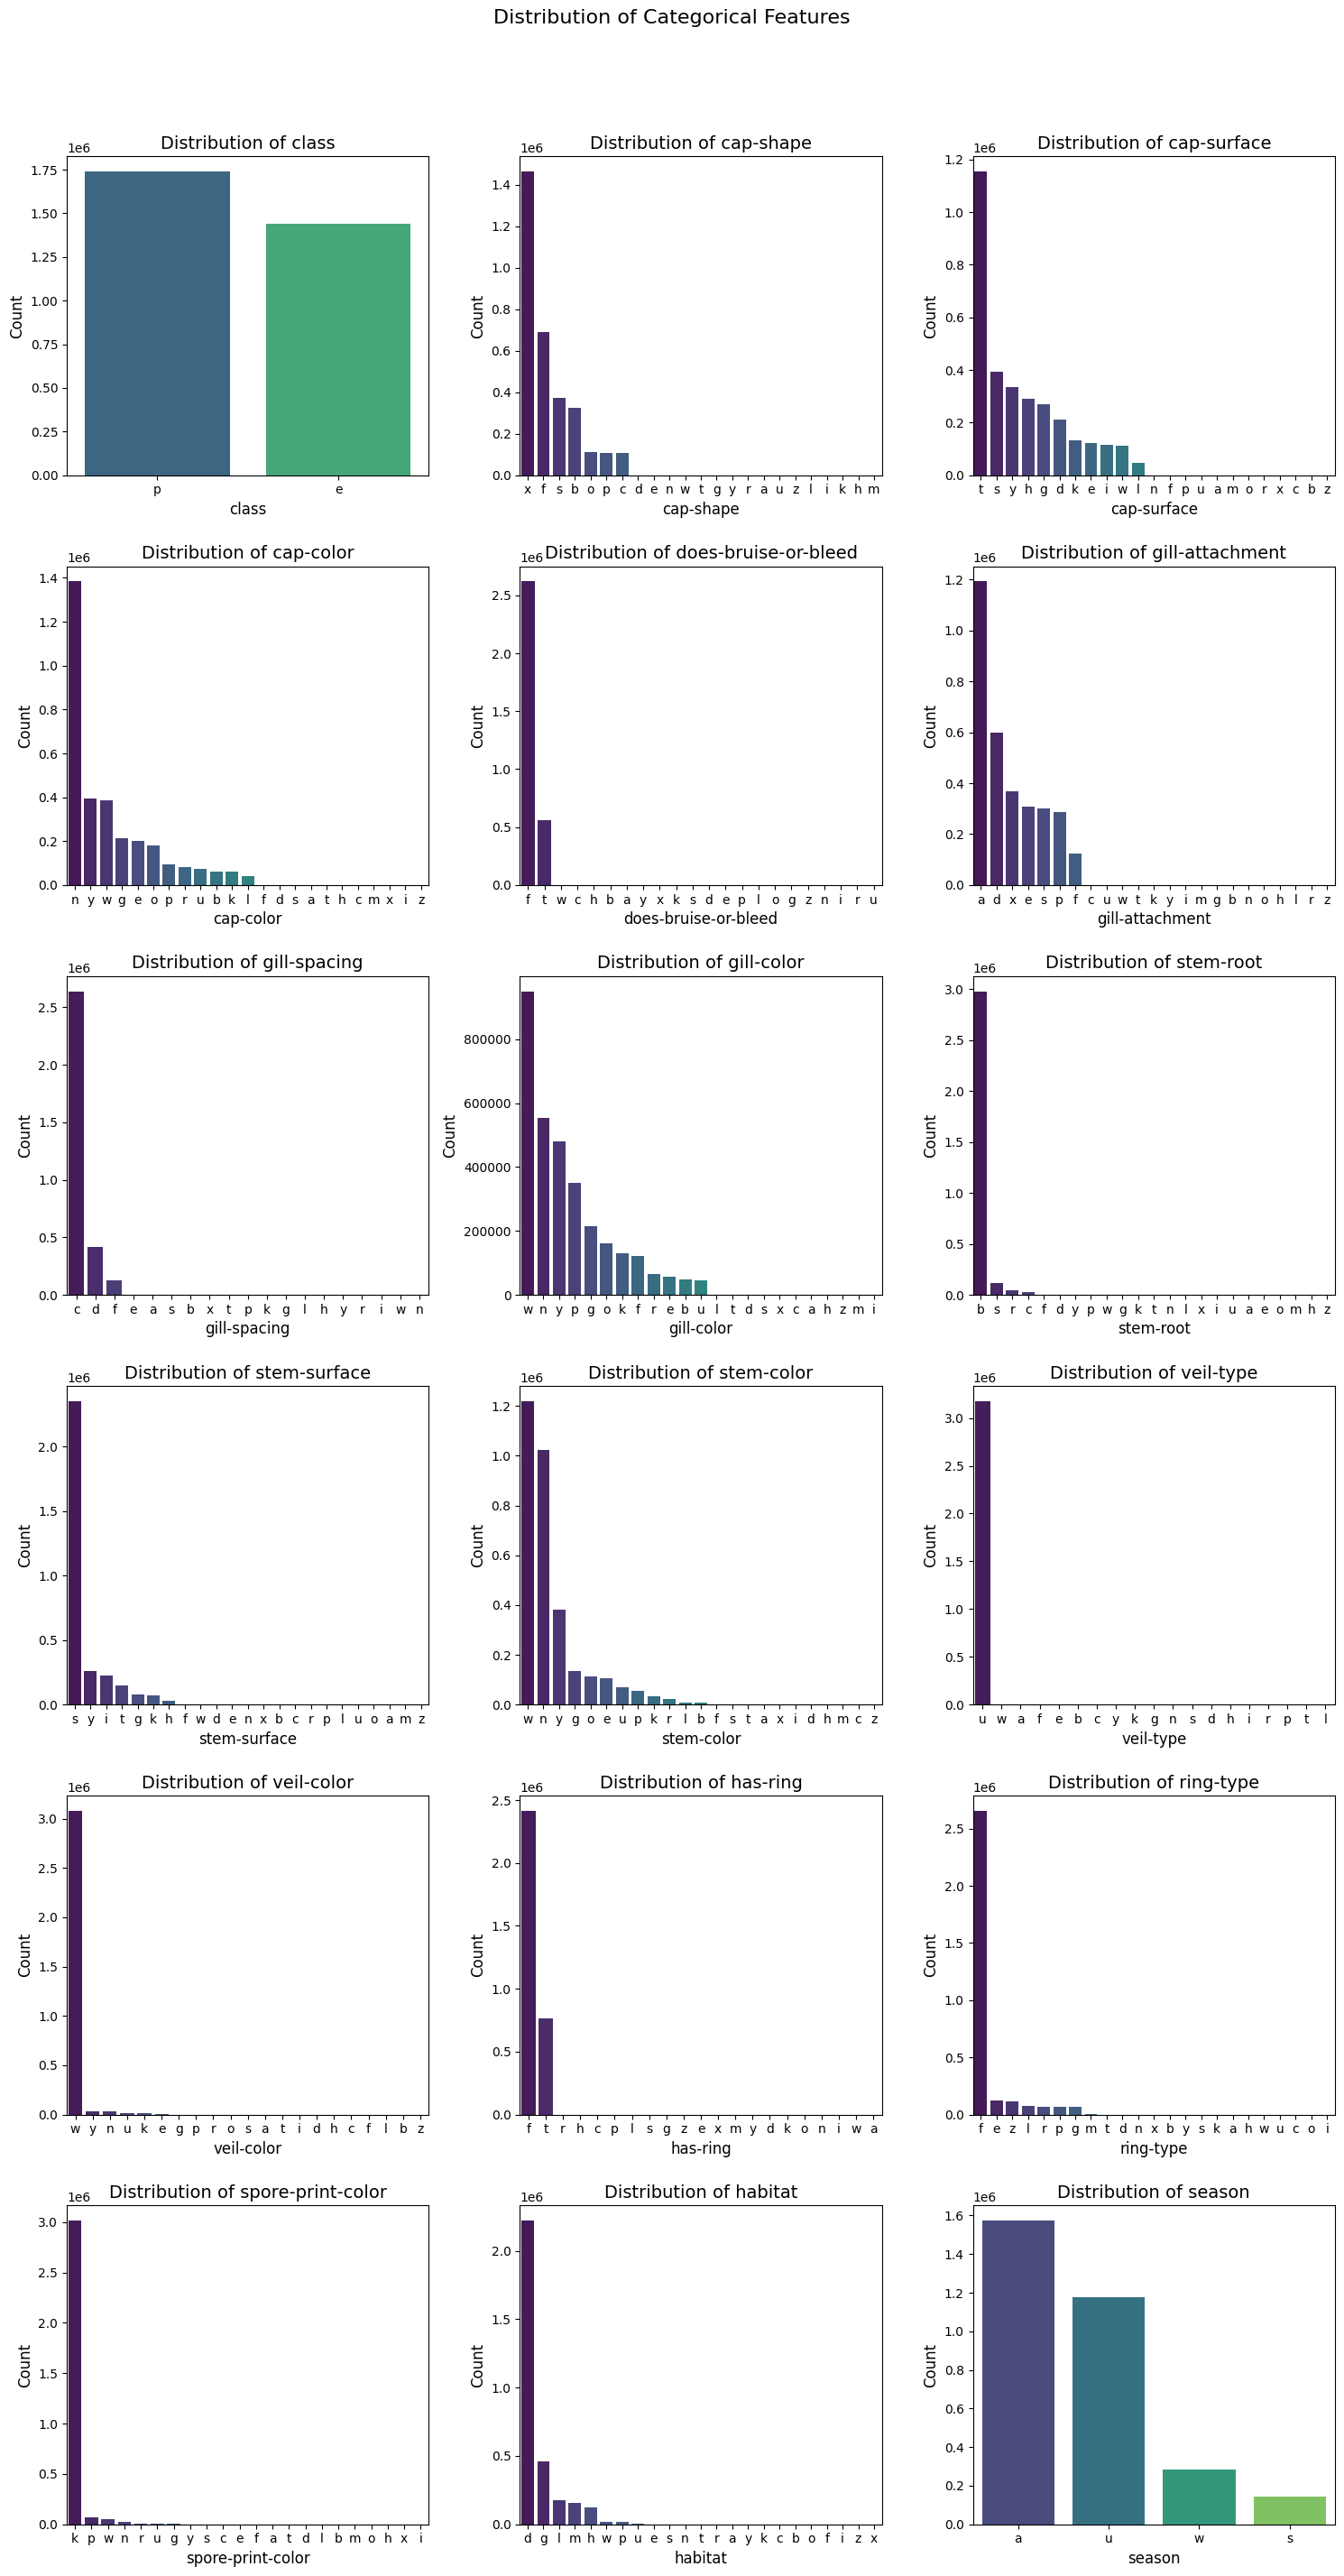

In [11]:
visualize_categorical_distributions(df)

### Categorizing Low-Frequency Values

This section introduces a function `categorize_low_frequency_values(df_train, df_test, threshold=100)` that aims to address the problem of categories with very few occurrences in categorical columns. These low-frequency values can introduce noise into the model, so this function replaces them with the category `'Unknown'` to simplify the data and make it more manageable for machine learning models.

#### Function Breakdown:
1. **Parameters**:
   - `df_train`: The training dataset where the transformation will be applied.
   - `df_test`: The test dataset, which will undergo the same transformation for consistency.
   - `threshold`: The frequency threshold below which categories are replaced with `'Unknown'`. The default value is set to 100.

2. **Mapping Dictionary**:
   - The function returns a `mapping_dict` which stores the mappings of the replaced values for each column, allowing you to track which original categories were considered low-frequency and replaced by `'Unknown'`.

3. **Replacement Process**:
   - The function first identifies all the categorical columns in the dataset.
   - It calculates the frequency of each category in the training set. If the frequency of a category is below the defined `threshold`, it is added to the list of values to be replaced.
   - The replacement is then applied to both the training and test datasets to ensure that the same categories are handled consistently across both datasets.

4. **Application**:
   - After replacing the low-frequency values, the function returns the modified training and test datasets along with the mapping dictionary.
   - Finally, the `visualize_categorical_distributions(df)` function is called again to visualize the updated distribution of categorical values after the low-frequency categories have been replaced.

By using this function, you can effectively reduce the noise caused by rare categories and ensure that your model isn't influenced by these infrequent values, improving its generalization on unseen data.


In [12]:
def categorize_low_frequency_values(df_train, df_test, threshold=100):
    """
    Replaces categories with less than a given threshold in all categorical columns 
    with the category 'Unknown', applying the same transformation to both training and test datasets.
    
    Parameters:
    - df_train (pd.DataFrame): The training DataFrame.
    - df_test (pd.DataFrame): The test DataFrame.
    - threshold (int): Frequency threshold below which categories are replaced with 'Unknown'.

    Returns:
    - df_train (pd.DataFrame): Modified training DataFrame.
    - df_test (pd.DataFrame): Modified test DataFrame.
    - mapping_dict (dict): Dictionary containing the mappings of replaced values for each column.
    """
    mapping_dict = {}
    
    # Identify categorical columns
    categorical_columns = df_test.select_dtypes(include=['object']).columns

    for col in categorical_columns:
        # Find values to replace
        value_counts = df_train[col].value_counts()
        values_to_replace = value_counts[value_counts < threshold].index
        
        # Update mapping dictionary with replacement to 'Unknown'
        mapping_dict[col] = {value: 'Unknown' for value in values_to_replace}
        
        # Replace in training and test data
        df_train[col] = df_train[col].replace(values_to_replace, 'Unknown')
        df_test[col] = df_test[col].replace(values_to_replace, 'Unknown')

    return df_train, df_test, mapping_dict


In [13]:
df, test, mappings = categorize_low_frequency_values(df, test)

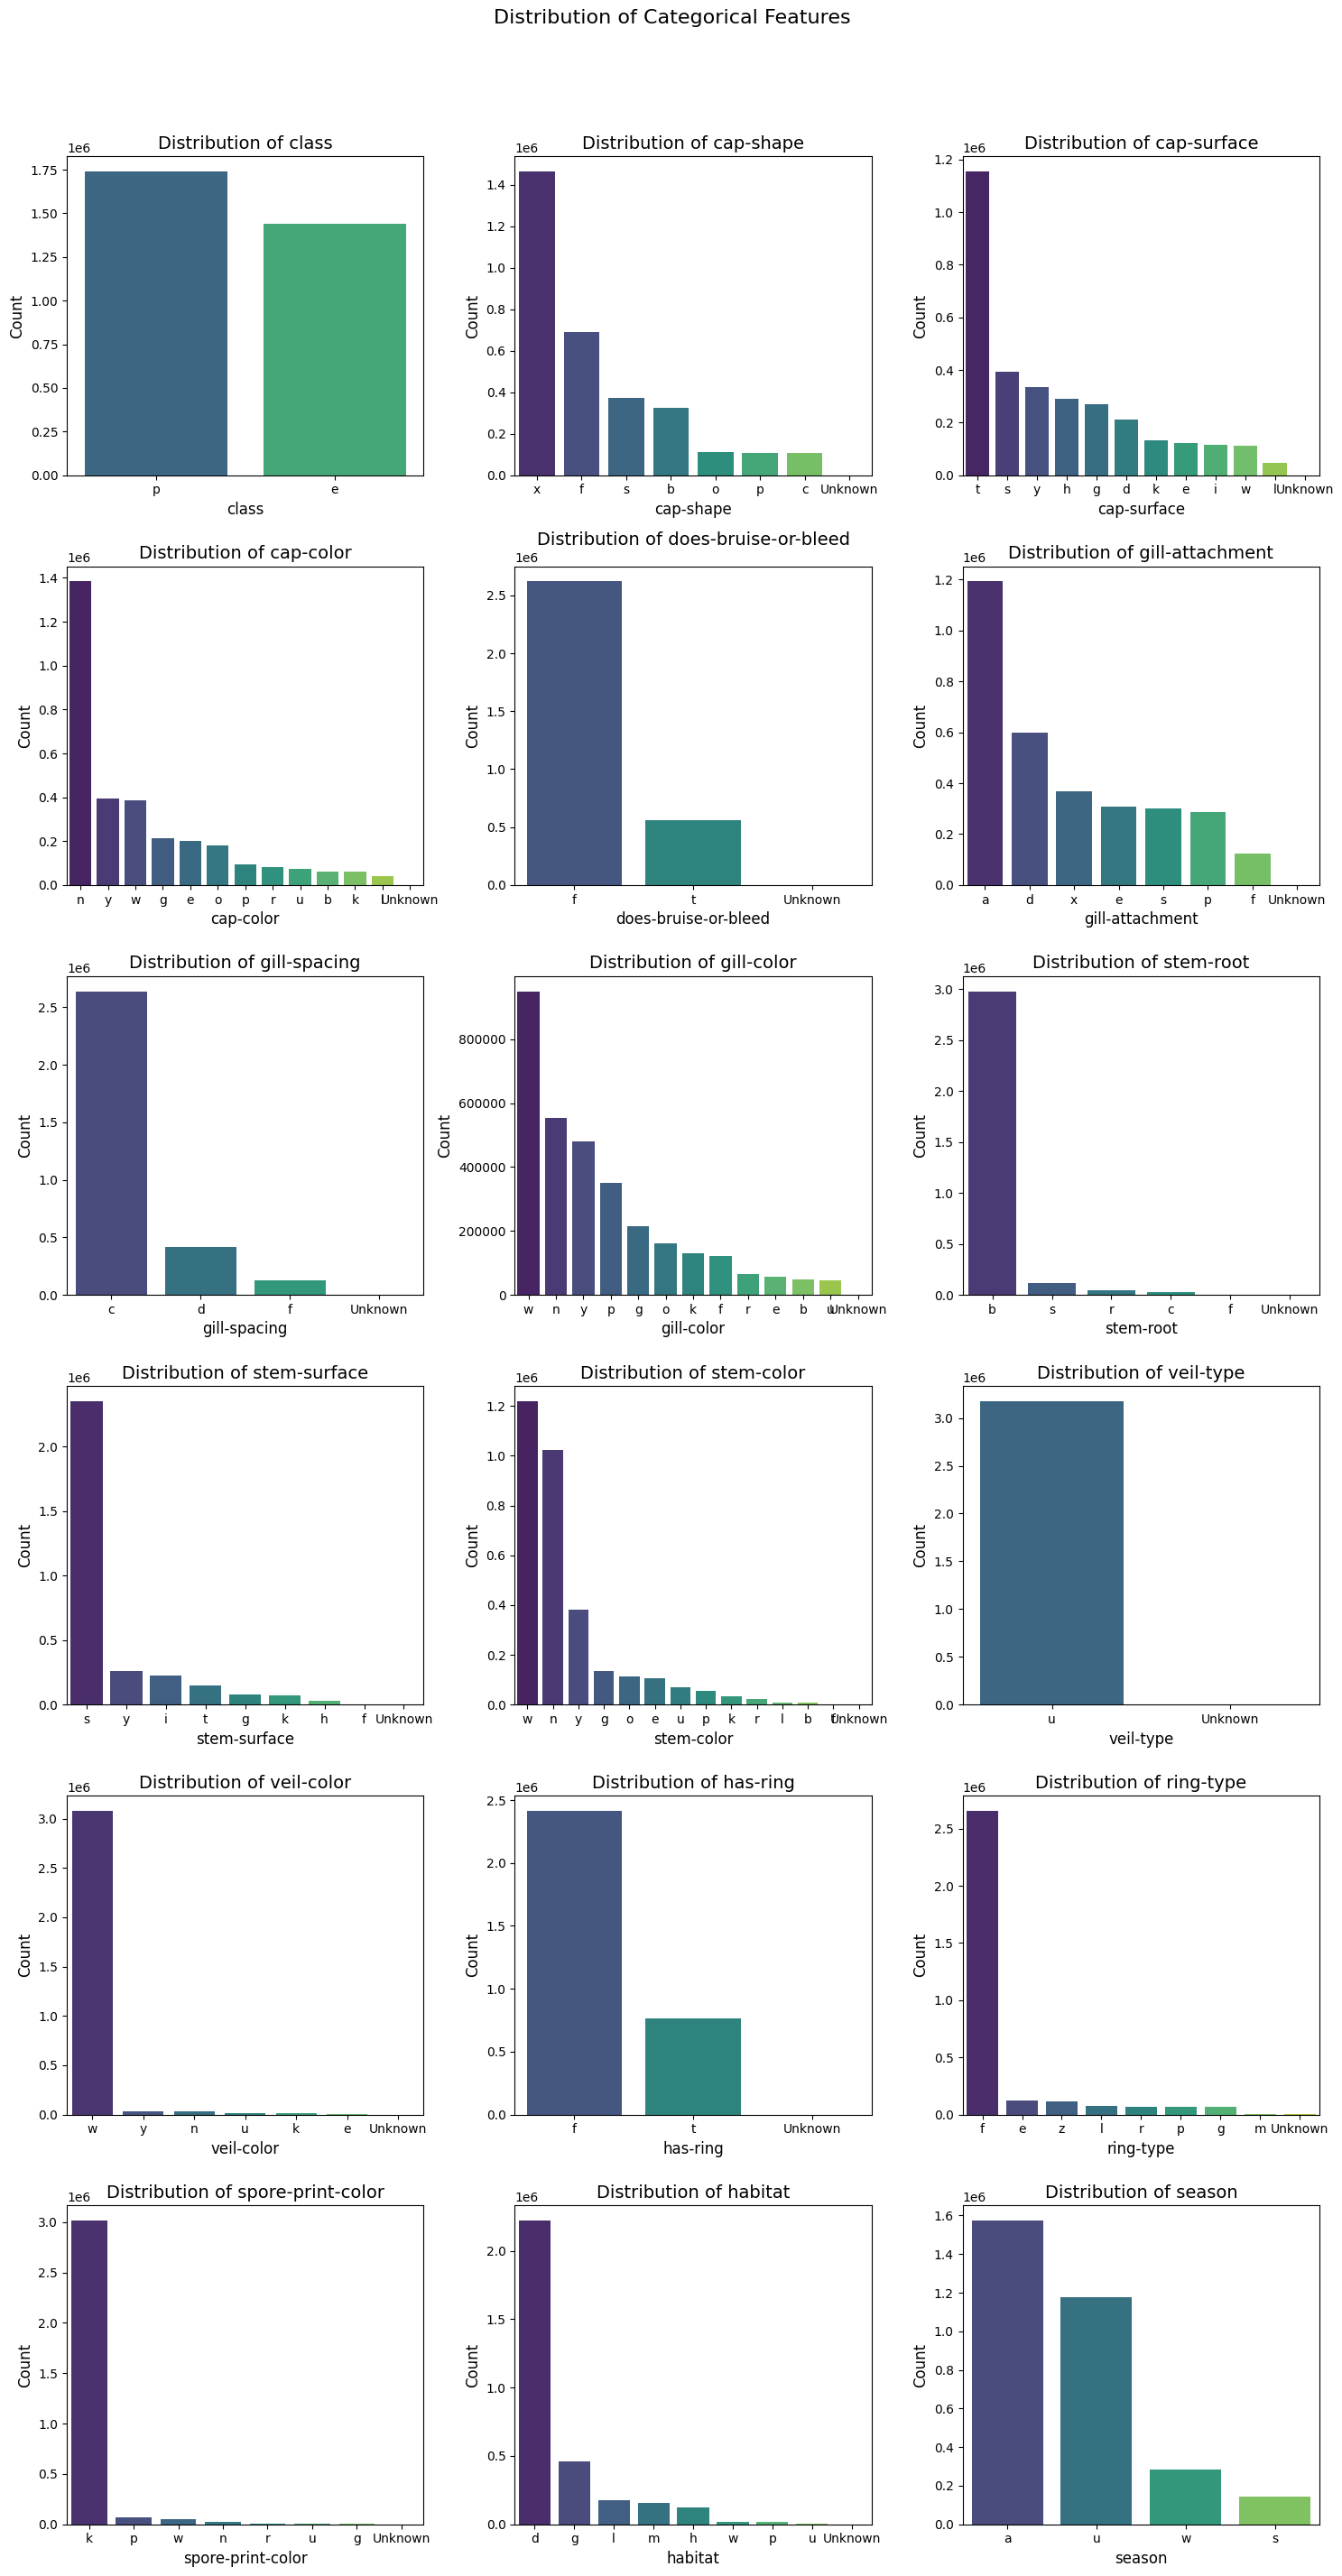

In [14]:
visualize_categorical_distributions(df)

### Visualizing the Distribution of Numerical Features

This section defines a function `visualize_numerical_distributions(df, exclude_columns='id')` which creates histograms and Kernel Density Estimation (KDE) plots for each numerical column in the DataFrame. The goal is to analyze the distribution of numerical features, helping you understand the data's underlying structure.

#### Function Breakdown:
1. **Parameters**:
   - `df`: The DataFrame containing numerical features that you want to visualize.
   - `exclude_columns`: A list of column names to exclude from visualization. The default is `'id'`, as ID columns are often not useful for visualization. This can be adjusted based on specific requirements.

2. **Identifying Numerical Columns**:
   - The function first identifies the numerical columns in the dataset, filtering out any columns specified in the `exclude_columns` parameter.

3. **Setting Up the Plot Grid**:
   - The function sets up a grid of subplots to visualize each numerical column. It uses 3 columns for the layout, and the number of rows is dynamically calculated based on the number of numerical features.
   - The overall figure size is adjusted to fit the number of subplots and ensure clarity in the visualization.

4. **Plotting Each Numerical Column**:
   - For each numerical feature, a histogram and KDE plot are created using Seaborn (`sns.histplot`). This allows for a combined visualization of the data's frequency distribution (via the histogram) and its probability density (via the KDE curve).
   - Titles and axis labels are added to make the plots easily interpretable.

5. **Cleaning Up Unused Subplots**:
   - If the number of numerical columns is fewer than the total number of subplots, the unused subplots are removed to maintain a clean layout.

6. **Final Layout Adjustments**:
   - The layout is further adjusted to provide proper spacing between plots and ensure that the overall title of the figure remains clearly visible.

By using this function, you can visualize the distribution of numerical features, which helps in understanding the central tendency, spread, and skewness of the data, as well as identifying any potential outliers or unusual patterns.


In [15]:
def visualize_numerical_distributions(df, exclude_columns='id'):
    """
    Visualizes the distribution of numerical features in the DataFrame using histograms and KDE plots,
    excluding specified columns.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the numerical features to visualize.
    - exclude_columns (list): List of column names to exclude from visualization.
    
    Returns:
    - None: Displays the plots.
    """
    # Ensure exclude_columns is a list
    if exclude_columns is None:
        exclude_columns = []

    # Identify numerical columns and exclude specified ones
    numerical_columns = df.select_dtypes(include=['number']).columns
    numerical_columns = [col for col in numerical_columns if col not in exclude_columns]

    # Set up the figure for multiple subplots
    num_cols = 3  # Number of columns for the subplot grid
    num_rows = (len(numerical_columns) + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))
    fig.suptitle('Distribution of Numerical Features', fontsize=16)

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each numerical column and create a histogram with KDE
    for i, col in enumerate(numerical_columns):
        sns.histplot(df[col], kde=True, ax=axes[i], color="skyblue", element="step", stat="density")
        axes[i].set_title(f'Distribution of {col}', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)
        axes[i].set_ylabel('Density', fontsize=12)

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the main title space
    plt.show()

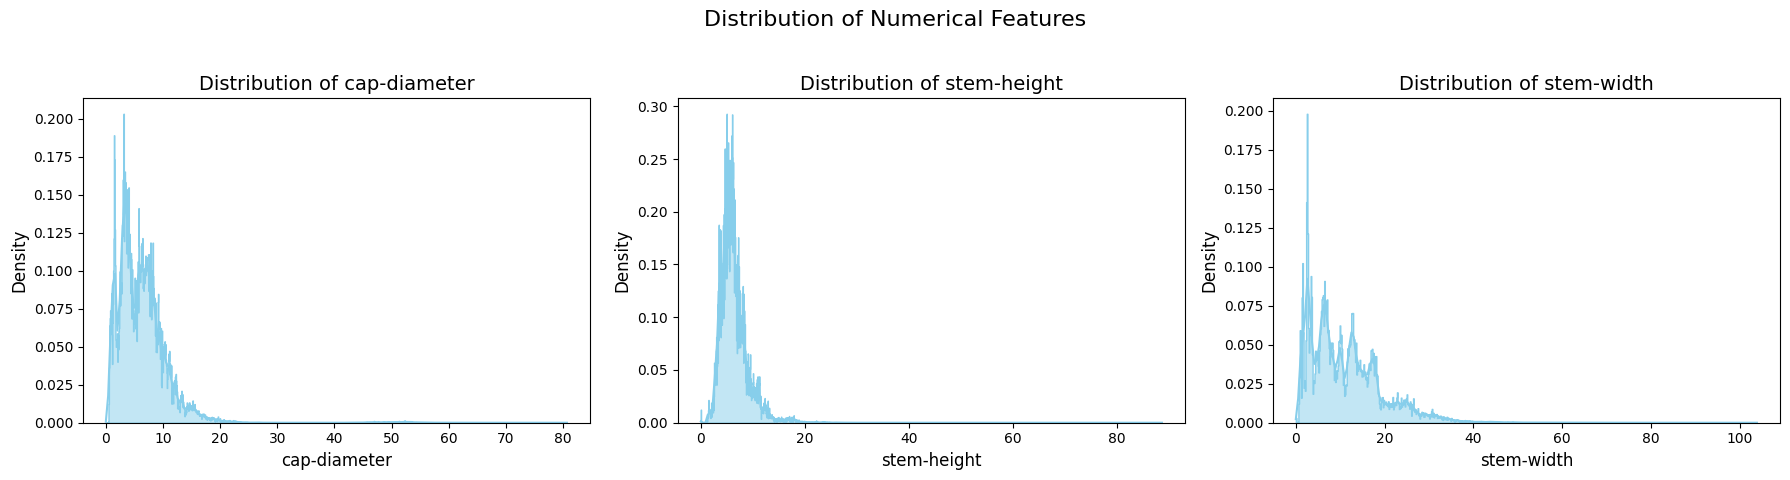

In [16]:
visualize_numerical_distributions(df)

### Handling Skewness in Numerical Features

In this section, a function `handle_skewness(df, threshold=1.0)` is defined to address the skewness present in the numerical features of a dataset. Skewness in data can lead to issues when building predictive models, especially those that assume normally distributed input features (e.g., linear regression models). This function applies the **Box-Cox transformation** to numerical columns where skewness exceeds a defined threshold, making the data more symmetric.

#### Function Breakdown:
1. **Parameters**:
   - `df`: The DataFrame containing the numerical features to transform.
   - `threshold`: A float value indicating the skewness threshold. If a column's skewness is greater than this value, it will be transformed. The default value is set to 1.0, meaning the function targets columns with high positive skewness.

2. **Identifying Skewed Columns**:
   - The function identifies all numerical columns in the DataFrame using `select_dtypes(include=['number'])`.
   - It then calculates the skewness of each column using `df[col].skew()`. Skewness greater than the threshold indicates that the column has a right (positive) skew.

3. **Applying Box-Cox Transformation**:
   - The **Box-Cox transformation** is applied to columns with high skewness. This transformation is designed to reduce skewness and stabilize variance in the data.
   - Since the Box-Cox transformation can only be applied to positive values, the function first shifts the data by adding 1 to any numerical values to ensure all values are positive.
   - After the transformation, the lambda value (used internally by the Box-Cox function) is saved in `lambda_dict` for each column.

4. **Returning Transformed Data**:
   - The function returns the transformed DataFrame and a dictionary containing the lambda values for each column. These lambda values can be useful for reversing the transformation later if needed.

#### Application:
After applying the `handle_skewness(df)` function, the skewness of the numerical columns is reduced, resulting in more symmetric and well-behaved distributions. The same transformation is applied to both the training and test datasets to maintain consistency. After the transformation, the `visualize_numerical_distributions(df)` function is called again to visualize the updated distribution of the numerical features and check the impact of the skewness correction.


In [17]:
def handle_skewness(df, threshold=1.0):
    """
    Applies Box-Cox transformation to numerical columns in the DataFrame where skewness exceeds a threshold.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - threshold (float): Skewness threshold to decide which columns to transform.
    
    Returns:
    - pd.DataFrame: DataFrame with transformed columns.
    - dict: Dictionary of lambda values used for Box-Cox transformation for each column.
    """
    numeric_cols = df.select_dtypes(include=['number']).columns
    lambda_dict = {}
    
    for col in numeric_cols:
        skewness = df[col].skew()
        # Check the skewness and ensure positive values for Box-Cox
        if skewness > threshold:
            # Adding 1 to shift all data to positive if there are zero or negative values
            df[col] = df[col] + 1
            df[col], fitted_lambda = boxcox(df[col])
            lambda_dict[col] = fitted_lambda
    
    return df, lambda_dict

# Example usage:
# df is your DataFrame containing the numerical data
df, lambda_values = handle_skewness(df)
test, lambda_test = handle_skewness(test)


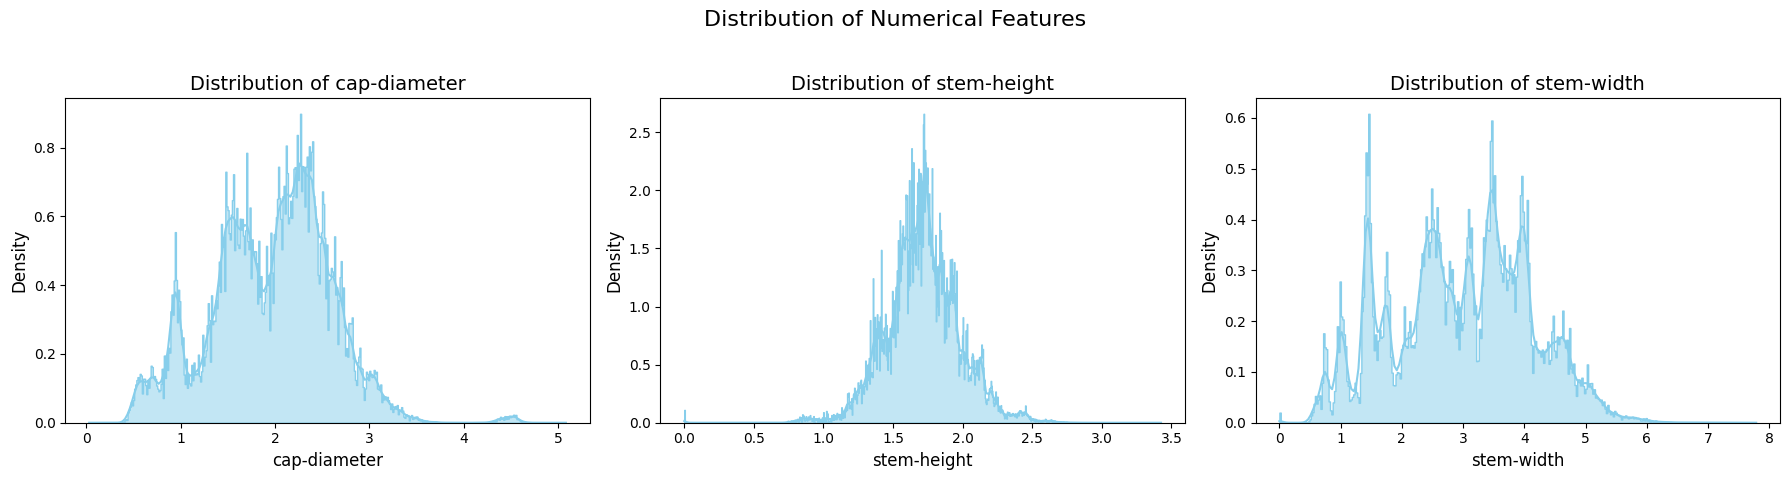

In [18]:
visualize_numerical_distributions(df, exclude_columns='id')

### Visualizing Numerical Features with Box Plots

In this section, a function `visualize_box_plots(df)` is defined to visualize the distribution of numerical features in a dataset using box plots. Box plots are useful for identifying the spread of data, central tendency, and the presence of outliers in numerical columns.

#### Function Breakdown:
1. **Identifying Numerical Columns**:
   - The function begins by selecting all numerical columns in the DataFrame using `select_dtypes(include=['number'])`. These are the columns for which box plots will be created.

2. **Setting Up the Plot Grid**:
   - The box plots are arranged in a grid layout with 3 columns per row. The number of rows is dynamically calculated based on the total number of numerical columns in the DataFrame.
   - The overall figure size is adjusted to accommodate all subplots, ensuring that each plot has enough space to be clearly visualized.

3. **Plotting Each Numerical Column**:
   - For each numerical column, a box plot is created using Seaborn's `sns.boxplot()`. A box plot provides a visual summary of:
     - The minimum, first quartile (Q1), median (Q2), third quartile (Q3), and maximum values.
     - Outliers, which are points that fall below Q1 or above Q3 by more than 1.5 times the interquartile range (IQR).
   - Titles and x-axis labels are added to each subplot to indicate the feature being visualized.

4. **Cleaning Up Unused Subplots**:
   - If the number of numerical columns is fewer than the total number of subplots, the unused subplots are removed to maintain a clean layout.

5. **Final Layout Adjustments**:
   - The layout is further adjusted to provide proper spacing between the plots, ensuring the main title and individual box plots are clearly visible.

#### Purpose of Box Plots:
Box plots are particularly useful for identifying outliers in the data. By visualizing each numerical feature in this way, you can easily spot extreme values that might need further attention (e.g., imputation, removal, or special handling) before proceeding with model building or analysis.

By calling `visualize_box_plots(df)`, the distribution and outliers of all numerical features in the DataFrame are clearly displayed, helping in exploratory data analysis (EDA).


In [19]:
def visualize_box_plots(df):
    """
    Visualizes the distribution of numerical features in the DataFrame using box plots to identify outliers.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the numerical features to visualize.
    
    Returns:
    - None: Displays the box plots.
    """
    # Identify numerical columns
    numerical_columns = df.select_dtypes(include=['number']).columns

    # Set up the figure for multiple subplots
    num_cols = 3  # Number of columns for the subplot grid
    num_rows = (len(numerical_columns) + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))
    fig.suptitle('Box Plot of Numerical Features', fontsize=16)

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each numerical column and create a box plot
    for i, col in enumerate(numerical_columns):
        sns.boxplot(x=df[col], ax=axes[i], color="skyblue")
        axes[i].set_title(f'Box Plot of {col}', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the main title space
    plt.show()

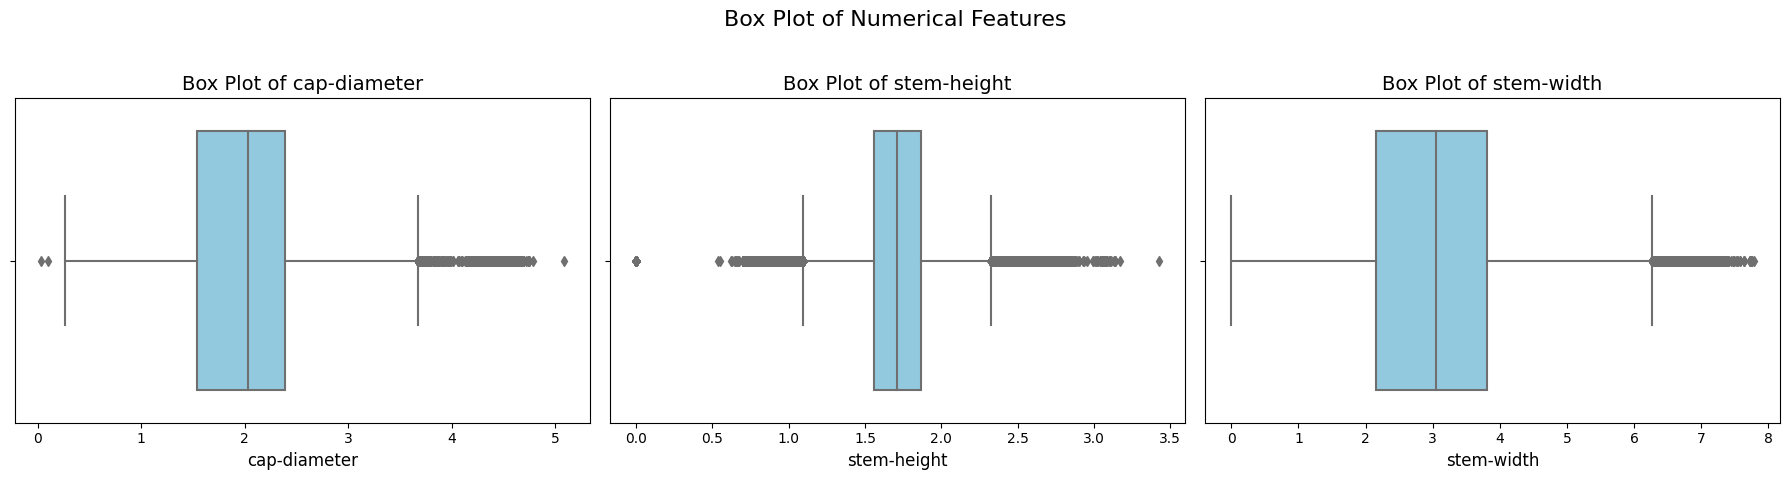

In [20]:
visualize_box_plots(df)

### Calculating and Handling Outliers

Outliers can have a significant impact on statistical analysis and machine learning models, as they can distort the results and lead to overfitting. This section introduces two functions: one for calculating the percentage of outliers and another for handling them by capping their values based on the **Interquartile Range (IQR) method**.

---

#### 1. Calculating the Percentage of Outliers: `calculate_outliers_percentage(df)`

This function calculates the percentage of outliers in each numerical column based on the **IQR method**.

##### IQR Method:
- **Q1 (First Quartile)**: The 25th percentile of the data.
- **Q3 (Third Quartile)**: The 75th percentile of the data.
- **IQR (Interquartile Range)**: The range between Q3 and Q1, i.e., IQR = Q3 - Q1.
- **Lower Bound**: Q1 - 1.5 * IQR (anything below this is considered an outlier).
- **Upper Bound**: Q3 + 1.5 * IQR (anything above this is considered an outlier).

For each numerical column:
- The function calculates the Q1, Q3, and IQR.
- Outliers are identified as any value outside the lower or upper bounds.
- The percentage of data considered as outliers is then printed for each numerical column.

This provides a clear understanding of how prevalent outliers are in your data.

---

#### 2. Handling Outliers: `handle_outliers(df)`

After identifying outliers, this function handles them by **capping**. Capping is a technique where the extreme values (outliers) are replaced with boundary values instead of removing them, which ensures no data is lost while reducing the influence of extreme values.

##### How It Works:
- The function again calculates the **IQR**, **lower bound**, and **upper bound** for each numerical column.
- Any value below the lower bound is replaced with the lower bound, and any value above the upper bound is replaced with the upper bound using the `clip()` function.
- This ensures that no outliers remain outside the acceptable range while preserving the data's overall structure.

By capping the outliers, the data is now less influenced by extreme values, which can improve the stability of machine learning models.

---

#### Application:
After calculating and handling outliers in both the training and test datasets, the `handle_outliers(df)` function is applied to cap the extreme values. This is essential to maintain consistency across the datasets and ensure that no outliers distort the analysis or modeling.

```python
# Example usage:
calculate_outliers_percentage(df)
df = handle_outliers(df)
test = handle_outliers(test)


In [21]:
def calculate_outliers_percentage(df):
    """
    Calculates the percentage of data considered outliers based on the IQR method for each numerical column.

    Parameters:
    - df (pd.DataFrame): DataFrame to analyze.

    Returns:
    - None: Prints the percentage of outliers for each numerical column.
    """
    outlier_counts = {}
    for column in df.select_dtypes(include=['number']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Calculate outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_counts[column] = len(outliers)

    # Print the percentage of outliers for each column
    for column in outlier_counts:
        percentage = (outlier_counts[column] / len(df)) * 100
        print(f"Percentage of outliers in {column}: {percentage:.2f}%")

# Example usage:
calculate_outliers_percentage(df)


Percentage of outliers in cap-diameter: 0.44%
Percentage of outliers in stem-height: 2.64%
Percentage of outliers in stem-width: 0.06%


In [22]:
def handle_outliers(df):
    """
    Handles outliers in a DataFrame by capping based on the IQR method.

    Parameters:
    - df (pd.DataFrame): DataFrame to process.

    Returns:
    - pd.DataFrame: DataFrame with outliers handled.
    """
    for column in df.select_dtypes(include=['number']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Capping
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    
    return df

# Apply to both training and test datasets
df = handle_outliers(df)
test = handle_outliers(test)

### Preprocessing: Scaling, Encoding, and Preparing Features

This section focuses on preprocessing the numeric and categorical features in both the training and test datasets to prepare them for model training. Key steps include standardizing numeric features and encoding categorical features.

---

#### 1. Scaling Numeric Features

To ensure that the numerical features have a uniform scale, they are standardized using the **StandardScaler** from `sklearn`. Standardizing the data transforms it to have a mean of 0 and a standard deviation of 1, which is especially important for models like logistic regression or neural networks.

Steps:
- **Extract Numeric Features**: The numeric features (in this case, `cap-diameter`, `stem-height`, and `stem-width`) are extracted from both the training and test datasets.
- **Fit and Transform**: The `StandardScaler` is fitted on the training data using `fit_transform()` and then applied to the test data using `transform()`.
- **Update DataFrames**: The scaled features are then placed back into the original training and test DataFrames.

This ensures that the numeric features in both the training and test datasets have the same scale, which is critical for ensuring that the model is not biased by features on different scales.

---

#### 2. Preparing the Target Variable

The target variable, `class`, is extracted from the DataFrame. Since this is a categorical label, it needs to be converted into numerical form for machine learning models.

Steps:
- **Encoding the Label**: The `LabelEncoder` is used to transform the categorical target variable (`class`) into numerical values. This is necessary because most machine learning models expect numeric inputs for classification tasks.

---

#### 3. Encoding Categorical Features

Categorical features are often non-numeric and need to be transformed into numerical values for most machine learning algorithms. In this case, an **OrdinalEncoder** is used, which assigns a unique numeric value to each category.

Steps:
- **Extract Categorical Columns**: All categorical columns (excluding the target column) are identified.
- **Ordinal Encoding**: The `OrdinalEncoder` is applied to the categorical features. It is fit on the training data and then applied to the test data to ensure consistency.
  - The parameter `handle_unknown='use_encoded_value'` ensures that any unseen categories in the test data are encoded with a default value of `-1`.

---

#### 4. Verifying the Data

After encoding, the function prints the remaining object-type columns in the training DataFrame and the data types in the test DataFrame. This is useful for verifying that all categorical features have been correctly encoded and that no object-type columns remain (except, perhaps, the target variable).

By the end of this process, both the training and test datasets are fully numeric, and all features are ready for model training.


In [23]:
numeric_features = ['cap-diameter', 'stem-height', 'stem-width']

# Extract numeric features for training and test datasets
X_train_numeric = df[numeric_features]
X_test_numeric = test[numeric_features]

# Standardize the numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

df[numeric_features] = X_train_scaled
test[numeric_features] = X_test_scaled

In [24]:
# prepare target
y = df['class']  # Target

# Encoding the label
le = LabelEncoder()
df['class'] = y = le.fit_transform(df['class'])

In [25]:
# from sklearn.preprocessing import OrdinalEncoder

cat_cols = df.select_dtypes(include=['object']).columns
cat_cols = cat_cols[cat_cols != 'class']

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

df[cat_cols] = ordinal_encoder.fit_transform(df[cat_cols].astype(str))
test[cat_cols] = ordinal_encoder.transform(test[cat_cols].astype(str))

print(df.select_dtypes(include=['object']).columns)
print(test.dtypes)

Index([], dtype='object')
cap-diameter            float64
cap-shape               float64
cap-surface             float64
cap-color               float64
does-bruise-or-bleed    float64
gill-attachment         float64
gill-spacing            float64
gill-color              float64
stem-height             float64
stem-width              float64
stem-root               float64
stem-surface            float64
stem-color              float64
veil-type               float64
veil-color              float64
has-ring                float64
ring-type               float64
spore-print-color       float64
habitat                 float64
season                  float64
dtype: object


### Feature Selection with Chi-Square, Mutual Information, and Random Forest

In this notebook, we start with **Chi-Square** feature selection, and in the upcoming sections, we will implement two other popular methods: **Mutual Information** and **Random Forest**. Each of these methods helps us identify the most important features that can impact our target variable in a classification problem.

#### 1. **Chi-Square Test (Chi2)**
The **Chi-Square (χ²) test** is a statistical method used to determine the dependence between two categorical variables. In our case, we use it to evaluate the relationship between each feature and the target variable.

- **Type of Features**: Chi2 is applied to **categorical features** and a **categorical target**.
- **Sensitivity**:
  - **Outliers**: Not sensitive to outliers.
  - **Missing Data**: Cannot handle missing data. We should handle missing values beforehand.
- **Category**: It is a **filter method**, as it independently evaluates each feature against the target variable.
  
Chi2 outputs a score for each feature based on its relevance to the target. We can then rank the features and select the most significant ones based on their Chi2 scores.

```python
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

# Select categorical columns and encode them
categorical_columns = ['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
                       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
                       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
                       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
                       'habitat', 'season']

df_Categorical = df[categorical_columns]

label_encoders = {}
for column in df_Categorical.columns:
    tem_le = LabelEncoder()
    df_Categorical[column] = tem_le.fit_transform(df_Categorical[column])
    label_encoders[column] = tem_le

# Apply Chi2
chi2_scores, p_values = chi2(df_Categorical, df['class'])

importance = pd.DataFrame({
    'Feature': df_Categorical.columns,
    'Chi2 Score': chi2_scores,
    'P-value': p_values
}).sort_values(by='Chi2 Score', ascending=False)

print(importance)


In [26]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

categorical_columns = [ 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'
    
]
df_Categorical = df[categorical_columns]

label_encoders = {}
for column in df_Categorical.columns:
    tem_le = LabelEncoder()
    df_Categorical[column] = tem_le.fit_transform(df_Categorical[column])
    label_encoders[column] = tem_le

chi2_scores, p_values = chi2(df_Categorical, df['class'])

importance = pd.DataFrame({
    'Feature': df_Categorical.columns,
    'Chi2 Score': chi2_scores,
    'P-value': p_values
})

importance = importance.sort_values(by='Chi2 Score', ascending=False)

print(importance)


                 Feature    Chi2 Score        P-value
9             stem-width  5.635393e+07   0.000000e+00
0           cap-diameter  2.297892e+07   0.000000e+00
8            stem-height  9.754314e+05   0.000000e+00
5        gill-attachment  5.681041e+04   0.000000e+00
1              cap-shape  3.346234e+04   0.000000e+00
10             stem-root  2.415882e+04   0.000000e+00
16             ring-type  2.253306e+04   0.000000e+00
12            stem-color  1.948272e+04   0.000000e+00
7             gill-color  1.717728e+04   0.000000e+00
19                season  1.478094e+04   0.000000e+00
3              cap-color  1.031007e+04   0.000000e+00
2            cap-surface  7.865608e+03   0.000000e+00
11          stem-surface  5.480199e+03   0.000000e+00
6           gill-spacing  4.979657e+03   0.000000e+00
14            veil-color  1.887776e+03   0.000000e+00
18               habitat  1.715787e+03   0.000000e+00
15              has-ring  1.160066e+03  2.912107e-254
17     spore-print-color  7.

### Feature Importance with Random Forest Classifier

In this section, we apply the **Random Forest Classifier** to determine the importance of each feature in predicting the target variable. Random Forest is an ensemble learning method that combines multiple decision trees to improve accuracy and reduce overfitting. The feature importance is derived based on how much a particular feature contributes to reducing the impurity (e.g., Gini impurity) in the trees.

#### Steps:

1. **Feature Selection**: 
   - We extract the categorical features in the dataset and assign them to `X`, while the target variable (`class`) is assigned to `y`.

2. **Random Forest Classifier**: 
   - We initialize a `RandomForestClassifier` with 100 estimators (trees) and a fixed random state to ensure reproducibility of results.
   - The model is then trained (fitted) using the features (`X`) and the target (`y`).

3. **Feature Importance Extraction**: 
   - Once the model is trained, we extract the **feature importances** from the random forest. This method calculates the importance of each feature based on how much it contributes to reducing the overall error.
   
4. **Ranking the Features**: 
   - The feature importances are stored in a DataFrame and sorted in descending order of importance, so we can easily see which features have the greatest impact on predicting the target variable.

```python
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Extract features and target
X = df_Categorical
y = df['class']

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Extract feature importances
feature_importances = rf.feature_importances_

# Create DataFrame for feature importances
importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_rf)


In [27]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
categorical_columns = [ 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'
    
]
df_Categorical = df[categorical_columns]
X = df_Categorical  
y = df['class']  

rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X, y)

feature_importances = rf.feature_importances_

importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

importance_rf = importance_rf.sort_values(by='Importance', ascending=False)

print(importance_rf)


                 Feature  Importance
9             stem-width    0.130589
2            cap-surface    0.088729
5        gill-attachment    0.080957
0           cap-diameter    0.080111
12            stem-color    0.079218
7             gill-color    0.073120
8            stem-height    0.068288
11          stem-surface    0.057123
6           gill-spacing    0.052094
1              cap-shape    0.051442
3              cap-color    0.049475
16             ring-type    0.041752
4   does-bruise-or-bleed    0.032070
18               habitat    0.029932
10             stem-root    0.027164
15              has-ring    0.024529
17     spore-print-color    0.012193
19                season    0.011190
14            veil-color    0.010021
13             veil-type    0.000002


### Feature Selection with Mutual Information

In this section, we use **Mutual Information** to assess the importance of categorical features in predicting the target variable. Mutual Information is a non-parametric method that measures the dependency between variables, quantifying how much information one feature gives about the target.

#### Steps:

1. **Feature and Target Selection**:
   - We extract the categorical features and assign them to `X`, while the target variable (`class`) is assigned to `y`.
   
2. **Train-Test Split**:
   - To ensure the evaluation is robust, we split the dataset into a training set (80%) and a test set (20%) using `train_test_split`. This prevents overfitting and allows us to later validate the performance on unseen data.

3. **Mutual Information Scores**:
   - Using `mutual_info_classif` from `sklearn`, we compute the **Mutual Information (MI) scores** for the training data. This method measures the amount of information gained about the target by knowing a specific feature. A higher MI score indicates a stronger dependency between the feature and the target.
   
4. **Ranking the Features**:
   - The Mutual Information scores are stored in a DataFrame, and the features are sorted in descending order based on their MI scores. This helps us identify the features that carry the most information about the target variable.

```python
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
import pandas as pd

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate Mutual Information scores
mi_scores = mutual_info_classif(X_train, y_train)

# Create DataFrame for feature importance based on MI
importance_mi = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information Score': mi_scores
}).sort_values(by='Mutual Information Score', ascending=False)

print(importance_mi)


In [28]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
import pandas as pd

X = df_Categorical  
y = df['class']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mi_scores = mutual_info_classif(X_train, y_train)

importance_mi = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information Score': mi_scores
})

importance_mi = importance_mi.sort_values(by='Mutual Information Score', ascending=False)

print(importance_mi)


                 Feature  Mutual Information Score
10             stem-root                  0.258532
17     spore-print-color                  0.250026
13             veil-type                  0.246825
14            veil-color                  0.245497
6           gill-spacing                  0.235888
16             ring-type                  0.204015
15              has-ring                  0.199860
4   does-bruise-or-bleed                  0.198790
11          stem-surface                  0.198213
12            stem-color                  0.117417
18               habitat                  0.111449
1              cap-shape                  0.107271
2            cap-surface                  0.094265
3              cap-color                  0.085955
19                season                  0.078460
7             gill-color                  0.071808
9             stem-width                  0.068442
5        gill-attachment                  0.067653
0           cap-diameter       

### Feature Selection with ANOVA F-Test

In this section, we use the **ANOVA F-test** to evaluate the importance of categorical features in predicting the target variable. ANOVA (Analysis of Variance) is a statistical method used to test whether there are significant differences between the means of different groups, making it useful for identifying features that have the greatest impact on a classification target.

#### Steps:

1. **Feature and Target Selection**:
   - We extract the categorical features and assign them to `X`, while the target variable (`class`) is assigned to `y`.
   
2. **Train-Test Split**:
   - To ensure robust evaluation, we split the dataset into a training set (80%) and a test set (20%) using `train_test_split`. This helps avoid overfitting and allows us to evaluate the performance on unseen data.

3. **Scaling the Data**:
   - Since the ANOVA F-test is sensitive to the scale of the input data, we apply a **MinMaxScaler** to normalize the features. This transformation scales the data to a range between 0 and 1, ensuring that all features have equal weight in the ANOVA test.

4. **ANOVA F-Test**:
   - We use the `f_classif` function from `sklearn` to perform the ANOVA F-test. This method calculates the **F-scores** for each feature and returns their corresponding **p-values**.
   - The F-score represents how well the feature distinguishes between classes, with a higher F-score indicating a more significant feature. The p-value tells us whether the relationship between the feature and the target is statistically significant.

5. **Ranking the Features**:
   - The F-scores and p-values are stored in a DataFrame, and the features are sorted in descending order of their F-scores. This helps us easily identify which features have the strongest impact on predicting the target variable.

```python
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Perform ANOVA F-test
f_scores, p_values = f_classif(X_train_scaled, y_train)

# Create DataFrame for feature importance based on ANOVA F-test
importance_anova = pd.DataFrame({
    'Feature': X.columns,
    'F Score': f_scores,
    'P-value': p_values
}).sort_values(by='F Score', ascending=False)

print(importance_anova)


In [29]:
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

X = df_Categorical  
y = df['class']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

f_scores, p_values = f_classif(X_train_scaled, y_train)

importance_anova = pd.DataFrame({
    'Feature': X.columns,
    'F Score': f_scores,
    'P-value': p_values
})

importance_anova = importance_anova.sort_values(by='F Score', ascending=False)

print(importance_anova)


                 Feature        F Score        P-value
9             stem-width  114882.099677   0.000000e+00
0           cap-diameter   98378.068999   0.000000e+00
14            veil-color   55733.800310   0.000000e+00
10             stem-root   33107.741761   0.000000e+00
5        gill-attachment   29084.966887   0.000000e+00
1              cap-shape   28610.105683   0.000000e+00
11          stem-surface   22236.287007   0.000000e+00
16             ring-type   20376.186755   0.000000e+00
6           gill-spacing   19884.745983   0.000000e+00
8            stem-height   18407.847229   0.000000e+00
12            stem-color   15500.020371   0.000000e+00
7             gill-color   11971.175063   0.000000e+00
19                season   10114.890773   0.000000e+00
15              has-ring    6351.193309   0.000000e+00
3              cap-color    6260.997672   0.000000e+00
2            cap-surface    4758.336883   0.000000e+00
4   does-bruise-or-bleed    3509.576288   0.000000e+00
17     spo

### Feature Selection with Lasso Regression

In this section, we use **Lasso Regression** to determine the importance of categorical features in predicting the target variable. **Lasso** (Least Absolute Shrinkage and Selection Operator) is a linear model that performs both regularization and feature selection. It penalizes the size of the regression coefficients, shrinking some coefficients to zero, effectively eliminating less important features from the model.

#### Steps:

1. **Feature and Target Selection**:
   - We extract the categorical features and assign them to `X`, while the target variable (`class`) is assigned to `y`.

2. **Train-Test Split**:
   - The dataset is split into training (80%) and test sets (20%) using `train_test_split`. This ensures that the model is trained on one part of the data and validated on the remaining part.

3. **Lasso Regression**:
   - A **Lasso** regression model is created with a regularization parameter `alpha=0.01`. The `alpha` parameter controls the strength of regularization, where a smaller alpha allows more features to be kept and a larger alpha increases the regularization, potentially eliminating more features.
   - The model is then trained on the training data (`X_train`, `y_train`) to learn the relationships between the features and the target variable.

4. **Extracting Feature Importances**:
   - After training the Lasso model, the feature coefficients (`coef_`) are extracted. These coefficients represent the "importance" of each feature, with larger absolute values indicating more important features.
   - Features with coefficients that are shrunk to zero are effectively considered unimportant by the model.
   
5. **Ranking the Features**:
   - The coefficients are stored in a DataFrame, and the features are ranked in descending order based on their importance (coefficients). This allows us to easily see which features the Lasso model deemed most important.

```python
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import pandas as pd

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Lasso with regularization parameter
lasso = Lasso(alpha=0.01)

# Fit the Lasso model
lasso.fit(X_train, y_train)

# Extract feature importances (coefficients)
feature_importances = lasso.coef_

# Create DataFrame for feature importance
importance_lasso = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_lasso)


In [30]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import pandas as pd

X = df_Categorical  
y = df['class']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso = Lasso(alpha=0.01)

lasso.fit(X_train, y_train)

feature_importances = lasso.coef_

importance_lasso = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

importance_lasso = importance_lasso.sort_values(by='Importance', ascending=False)

print(importance_lasso)


                 Feature  Importance
10             stem-root    0.066649
16             ring-type    0.031566
3              cap-color    0.012244
17     spore-print-color    0.001847
15              has-ring    0.000000
13             veil-type   -0.000000
2            cap-surface   -0.000000
4   does-bruise-or-bleed    0.000000
7             gill-color   -0.004012
8            stem-height   -0.008459
5        gill-attachment   -0.008874
12            stem-color   -0.010676
1              cap-shape   -0.018516
19                season   -0.020149
18               habitat   -0.022721
9             stem-width   -0.044048
11          stem-surface   -0.044162
0           cap-diameter   -0.046053
14            veil-color   -0.053066
6           gill-spacing   -0.064666


### Preparing Features and Splitting the Data

In this section, we prepare the features for model training and split the dataset into training and test sets. This is a crucial step before building any machine learning model, ensuring that the model is trained on one part of the data and validated on unseen data to evaluate its performance.

#### Steps:

1. **Feature Preparation**:
   - We remove the target column (`class`) from the dataset to prepare the feature matrix `X`.
   - Additionally, the column `'veil-type'` is dropped because it likely does not provide meaningful information or has no variance (e.g., a single value across all instances), which would make it irrelevant for modeling.

   ```python
   X = df.drop(['class', 'veil-type'], axis=1)


In [31]:
# Prepare features
X = df.drop(['class','veil-type'], axis=1)  # Features

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                                    shuffle=True, stratify=df['class'])


In [32]:
# mattews metrics for this competiton
def mcc_metric(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred = (y_pred > 0.5).astype(int) 
    mcc = matthews_corrcoef(y_true, y_pred)
    return 'mcc', mcc

### Training the XGBoost Classifier with Optuna-Optimized Parameters

In this section, we train an **XGBoost Classifier** using parameters that were optimized with **Optuna**, a hyperparameter optimization framework. XGBoost is a powerful and widely-used gradient boosting algorithm known for its performance in structured/tabular datasets.

#### Steps:

1. **XGBoost Parameters**:
   The `xgb_optuna_params` dictionary contains the hyperparameters for the XGBoost model that have been optimized using Optuna. Some key parameters include:
   - **`n_estimators`**: The number of boosting rounds (set to 10,000, allowing for potential early stopping).
   - **`alpha`**: L1 regularization term to control overfitting.
   - **`subsample`**: Fraction of samples to be used in each boosting round.
   - **`colsample_bytree`**: Fraction of features to be used for building each tree.
   - **`max_depth`**: Maximum depth of the trees, controlling the complexity of the model.
   - **`min_child_weight`**: Minimum sum of instance weights (hessian) required in a child node, controlling overfitting.
   - **`learning_rate`**: Step size shrinkage to control the learning rate of the model.
   - **`gamma`**: Minimum loss reduction required to make a split.

   These parameters have been fine-tuned to improve the performance of the model based on evaluation metrics like the **Matthews Correlation Coefficient (MCC)**.

   ```python
   xgb_optuna_params = {
       'n_estimators': 10000,
       'alpha': 0.0002,
       'subsample': 0.60,
       'colsample_bytree': 0.4,
       'max_depth': 13, 
       'min_child_weight': 10,
       'learning_rate': 0.002,
       'gamma': 5.6e-08,
   }


In [33]:
# Define the parameters for the XGBoost classifier
xgb_optuna_params = {
    'n_estimators': 10000,
    'alpha': 0.0002,
    'subsample': 0.60,
    'colsample_bytree': 0.4,
    'max_depth': 13, 
    'min_child_weight': 10,
    'learning_rate': 0.002,
    'gamma': 5.6e-08,
    # 'tree_method': 'gpu_hist',
    # 'device': "cuda"
}

# Garbage collection to free up memory
gc.collect()

# Initialize the XGBClassifier with the specified parameters
xgbclf = XGBClassifier(**xgb_optuna_params, tree_method='gpu_hist')

# Fit the model on the training data and evaluate using the MCC metric
XGB = xgbclf.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test, y_test)],
    eval_metric=mcc_metric,
#     early_stopping_rounds=100,
    verbose=200,
)



[0]	validation_0-logloss:0.68703	validation_0-mcc:0.00000
[200]	validation_0-logloss:0.49037	validation_0-mcc:0.97210
[400]	validation_0-logloss:0.36246	validation_0-mcc:0.97984
[600]	validation_0-logloss:0.27652	validation_0-mcc:0.98046
[800]	validation_0-logloss:0.21696	validation_0-mcc:0.98064
[1000]	validation_0-logloss:0.17258	validation_0-mcc:0.98100
[1200]	validation_0-logloss:0.14035	validation_0-mcc:0.98126
[1400]	validation_0-logloss:0.11756	validation_0-mcc:0.98140
[1600]	validation_0-logloss:0.09959	validation_0-mcc:0.98160
[1800]	validation_0-logloss:0.08601	validation_0-mcc:0.98181
[2000]	validation_0-logloss:0.07568	validation_0-mcc:0.98197
[2200]	validation_0-logloss:0.06748	validation_0-mcc:0.98216
[2400]	validation_0-logloss:0.06116	validation_0-mcc:0.98234
[2600]	validation_0-logloss:0.05652	validation_0-mcc:0.98250
[2800]	validation_0-logloss:0.05261	validation_0-mcc:0.98266
[3000]	validation_0-logloss:0.04955	validation_0-mcc:0.98277
[3200]	validation_0-logloss:0.0

In [34]:
y_pred = xgbclf.predict(X_test)
test_pred = xgbclf.predict(test.drop('veil-type', axis=1))

In [35]:
# Prepare submission
test_pred_labels = le.inverse_transform(test_pred)

sub['class'] = test_pred_labels
sub.to_csv('submission.csv', index=False)

In [ ]:
print(test_pred_labels)
print(test_pred)

In [ ]:
# Print accuracy and classification report
def mcc_metric(y_pred, y_true):
    y_pred = (y_pred > 0.5).astype(int) 
    mcc = matthews_corrcoef(y_true, y_pred)
    return 'mcc', mcc


print(f"\nMathews Cor Coef: {mcc_metric(y_test, y_pred)}")
print(f"\nAccuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot feature importance
feature_importance = xgbclf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importance')
plt.show()